In [1]:
import re
import math
import pickle
import requests
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from time import time
import IPython.display as Disp
from wordcloud import WordCloud
from pylatexenc.latex2text import LatexNodes2Text
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from underthesea import word_tokenize
from operator import itemgetter
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

In [2]:
df_org = pd.read_csv('2k_data_Sep.csv')
df = df_org.copy()
df.shape

(2000, 8)

In [3]:
def clean_function(text):  
    #lowercase
    text = text.lower()
    
#     #xoá ký tự đặc biệt, ký tự không phải alphanumeric 
#     text = re.sub("[^a-z0-9àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ]",' ', text)
    text = re.sub("[àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ]",'', text)    
#     #xoá leading zero
#     text = [e.lstrip('0') for e in text.split(' ')]
#     text = (' ').join(text)
    
    #replace extra spaces with single space
    text = re.sub(' +',' ',text)
    
    #xoá khoảng trắng ở đầu và cuối mỗi câu
    text = text.strip()
    
    #word tokenzie
    text = word_tokenize(text, format='text')
    return text

In [4]:
check_dup = df[['Lookup Text', 'Question Text']][df[['Lookup Text', 'Question Text']].duplicated()]
df = df.drop(check_dup.index)
df = df.reset_index(drop = True)
df.shape

(1962, 8)

In [5]:
df['index_org'] = df.index

df['lookup_plain'] = df['Lookup Text'].map(lambda x: LatexNodes2Text().latex_to_text(x))
df['question_plain'] = df['Question Text'].map(lambda x: LatexNodes2Text().latex_to_text(x))

df['clean_lookup'] = df['lookup_plain'].map(lambda x: clean_function(x))
df['clean_question'] = df['question_plain'].map(lambda x: clean_function(x))

df['char_count_lookup'] = df['clean_lookup'].str.len()
df['word_count_lookup'] = df['clean_lookup'].str.split().str.len()
df['average_word_length_lookup'] = df['char_count_lookup'] / df['word_count_lookup']

df['char_count_question'] = df['clean_question'].str.len()
df['word_count_question'] = df['clean_question'].str.split().str.len()
df['average_word_length_question'] = df['char_count_question'] / df['word_count_question']

In [6]:
with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    vn_stop_words = file.read()
vn_stop_words = vn_stop_words.split('\n') 

# combine Vietnamese stopwords and English stopwords
stop_words = ENGLISH_STOP_WORDS.union(vn_stop_words)

In [7]:
mask1 = df['Human Feedback'] == 'NOT MATCH'
mask2 = df['Human Feedback'] == 'MATCH'

df_neg = df[mask1].reset_index(drop = True)
df_pos = df[mask2].reset_index(drop = True)

print(df_neg.shape)
print(df_pos.shape)

(966, 19)
(996, 19)


In [8]:
df['diff_word'] = abs(df['word_count_question'] - df['word_count_lookup'])
df_neg['diff_word'] = abs(df_neg['word_count_question'] - df_neg['word_count_lookup'])
df_pos['diff_word'] = abs(df_pos['word_count_question'] - df_pos['word_count_lookup'])

my_bins = [-np.inf, 5, 10, 15, 20, np.inf]
my_labels = ['Very low', 'Low', 'Medium', 'High', 'Very high']

df['diff_bin'] = pd.cut(df['diff_word'], bins=my_bins, labels=my_labels)
df_neg['diff_bin'] = pd.cut(df_neg['diff_word'], bins=my_bins, labels=my_labels)
df_pos['diff_bin'] = pd.cut(df_pos['diff_word'], bins=my_bins, labels=my_labels)

In [9]:
tf = TfidfVectorizer(analyzer = 'word', stop_words = stop_words, min_df=0)
tfidf_matrix = tf.fit_transform(df_pos['clean_question'])
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(),
                                columns = tf.get_feature_names())
tfidf_matrix.head()
tfidf_matrix.shape

(996, 1805)

In [10]:
pca = PCA(n_components = 600, random_state=42)
question_pca = pca.fit_transform(tfidf_matrix)

Sum of variance: 0.9850469946412763



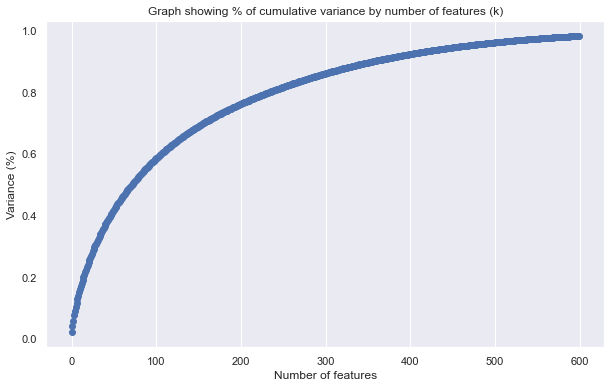

In [11]:
print('Sum of variance: {}'.format(pca.explained_variance_ratio_.sum()))
print()
sb.set_theme()
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker = "o")
plt.xlabel("Number of features")
plt.ylabel("Variance (%)")
plt.title("Graph showing % of cumulative variance by number of features (k)")
# plt.xlim([0, tfidf_matrix.shape[1] - 1])
plt.grid(axis = "y")
plt.show()

In [12]:
def cosine_search_all_pca(queries, tf, pca_matrix, data, top_result = 5, check_time = True):
    t0 = time()
    results = pd.DataFrame(columns = ['lookup_text', 'question_text', 'sim_score', 
                                      'cosine_word_count_question', 'cosine_diff_bin', 'cosine_image'])
    for q in queries:
        query = clean_function(q)
        query_tf = tf.transform([query])
        query_tf = pd.DataFrame(query_tf.toarray(),
                                columns = tf.get_feature_names())
        query_pca = pca.transform(query_tf)
        cosine_sim = cosine_similarity(query_pca, pca_matrix).flatten()
        related_index = cosine_sim.argsort()[-top_result:][::-1]
        cosine_sim = sorted(cosine_sim, reverse = True)
        similarities_score = cosine_sim[:top_result]
        result = pd.DataFrame({'lookup_text': q,
                               'question_text': data.iloc[related_index, :]['question_plain'].values,
                               'sim_score': similarities_score,
                               'cosine_word_count_question': data.iloc[related_index, :]['word_count_question'].values,
                               'cosine_diff_bin': data.iloc[related_index, :]['diff_bin'].values,
                               'cosine_image': data.iloc[related_index, :]['Question Image'].values}).head(1)
        results = pd.concat([results, result], ignore_index = True)
    times = time() - t0
    if check_time:
        if times < 60:
            print('Cosine search took {:.2f}s.'.format(times))
        else:
            print('Cosine search took {:.2f} minutes.'.format(times / 60))
    return results

In [21]:
results = cosine_search_all_pca(df_pos['lookup_plain'], tf, question_pca, df_pos)

Cosine search took 25.08s.


In [22]:
df_pos['search_result'] = results['question_text']
df_pos['score'] = results['sim_score']
df_pos['cosine_word_count_question'] = results['cosine_word_count_question']
df_pos['cosine_diff_bin'] = results['cosine_diff_bin']
df_pos['cosine_image'] = results['cosine_image']

In [23]:
mask5 = df_pos['question_plain'] != df_pos['search_result']

df_check_pos = df_pos[mask5]
df_check_pos.shape

(111, 26)

In [24]:
mask6 = df_pos['question_plain'] == df_pos['search_result']

df_match_pos = df_pos[mask6]
df_match_pos.shape

(885, 26)

In [25]:
def cosine_search_all(queries, tf, tfidf_matrix, data, top_result = 5, check_time = True):
    t0 = time()
    results = pd.DataFrame(columns = ['lookup_text', 'question_text', 'sim_score', 
                                      'cosine_word_count_question', 'cosine_diff_bin', 'cosine_image'])
    for q in queries:
        query = clean_function(q)
        query_tf = tf.transform([query])
        query_tf = pd.DataFrame(query_tf.toarray(),
                                columns = tf.get_feature_names())
        cosine_sim = cosine_similarity(query_tf, tfidf_matrix).flatten()
        related_index = cosine_sim.argsort()[-top_result:][::-1]
        cosine_sim = sorted(cosine_sim, reverse = True)
        similarities_score = cosine_sim[:top_result]
        result = pd.DataFrame({'lookup_text': q,
                               'question_text': data.iloc[related_index, :]['question_plain'].values,
                               'sim_score': similarities_score,
                               'cosine_word_count_question': data.iloc[related_index, :]['word_count_question'].values,
                               'cosine_diff_bin': data.iloc[related_index, :]['diff_bin'].values,
                               'cosine_image': data.iloc[related_index, :]['Question Image'].values}).head(1)
        results = pd.concat([results, result], ignore_index = True)
    if check_time:
        print('Time:', time() - t0)
    return results

In [26]:
results1 = cosine_search_all(df_pos['lookup_plain'], tf, tfidf_matrix, df_pos)

Time: 19.747328996658325


In [27]:
df_pos['search_result'] = results1['question_text']
df_pos['score'] = results1['sim_score']
df_pos['cosine_word_count_question'] = results1['cosine_word_count_question']
df_pos['cosine_diff_bin'] = results1['cosine_diff_bin']
df_pos['cosine_image'] = results1['cosine_image']

In [28]:
mask5 = df_pos['question_plain'] != df_pos['search_result']

df_check_pos = df_pos[mask5]
df_check_pos.shape

(112, 26)

In [29]:
mask6 = df_pos['question_plain'] == df_pos['search_result']

df_match_pos = df_pos[mask6]
df_match_pos.shape

(884, 26)